<a href="https://colab.research.google.com/github/jeyoor/iusb-applied-deep-learning-lecture/blob/feature%2F2019-09-18-lecture/dogs_and_cats_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dogs and Cats (Transfer Learning)

Compatability between Python2 and Python3

In [0]:
from __future__ import print_function

Extract training data (requires tarball to be available)

In [0]:
from six.moves import urllib
import tarfile
urllib.request.urlretrieve('https://github.com/jeyoor/iusb-applied-deep-learning-lecture/raw/master/dogs_cats_data_edited.tgz', 'dogs_cats_data_edited.tgz')
data_tarball = tarfile.open('/content/dogs_cats_data_edited.tgz', 'r:gz')
data_tarball.extractall()
data_tarball.close()


Imports and helpers we'll use later

In [4]:
import os
import time as t
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as skmetrics

from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50

from keras.models import Model
from keras.layers import Dense
from keras.optimizers import SGD
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img

def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    from keras.applications.vgg16 import preprocess_input
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]


Using TensorFlow backend.


For more information on the meaning of some of the constants below, see these links.

[Keras fit_generator documentation](https://keras.io/models/sequential/#fit_generator)

[StackExchange CrossValidated Question: "Tradeoff batch size vs. number of iterations"](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network)

[StackExchange CrossValidated Question: "What is batch size in neural network?"](https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network)

In [0]:
#create constants
SAMPLES_PER_EPOCH = 16
#using 10 epochs for training test
EPOCHS = 10
STEPS_PER_EPOCH = 1
VALIDATION_STEPS = 32
#dump full model to disk every 10 epochs
MODEL_SAVER_PERIOD = EPOCHS / 10

Creating data generators (note that training data generator is augmenting the training data, but the validation data generator is not augmenting)

In [0]:
#create training and validation data generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory='data/train',
                                                    target_size=[224, 224],
                                                    batch_size=SAMPLES_PER_EPOCH,
                                                    class_mode='binary')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
validation_generator = validation_datagen.flow_from_directory(directory='data/validation',
                                                              target_size=[224, 224],
                                                              batch_size=SAMPLES_PER_EPOCH,
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


Load models (VGG16, and ResNet50) with weights that were trained on the imagenet dataset

Keras source code for these models is available [here](https://github.com/keras-team/keras-applications/tree/master/keras_applications)

Don't forget to switch the branch to your current Keras version.


In [0]:
#initialize existing application nets
vgg16 = VGG16(weights='imagenet')
resnet50 = ResNet50(weights='imagenet')





553467904/553467096 [==============================] - 122s 0us/step



102858752/102853048 [==============================] - 9s 0us/step


Print a summary of the layers of each model.

For explanation of why the various layers are used for each model, see their individual research papers.

[Xception](https://arxiv.org/abs/1610.02357)

[VGG16](https://arxiv.org/abs/1610.02357)

[ResNet-50](https://arxiv.org/abs/1512.03385)

For more recent state of the art results on tasks like ImageNet, the "[Papers With Code](https://paperswithcode.com/sota/image-classification-on-imagenet)" site is a good resource.


In [0]:
vgg16.summary()
resnet50.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Change the output from predicting thousands of imagenet categories to predicting two categories (dogs vs. cats)

In [0]:
#bind 1D sigmoid output prediction to second-to-last layer
final_vgg16_layer = vgg16.get_layer('fc2').output
vgg16_prediction = Dense(output_dim=1, activation='sigmoid', name='logit')(final_vgg16_layer)
vgg16_model = Model(input=vgg16.input, output=vgg16_prediction)

final_resnet50_layer = resnet50.get_layer('avg_pool').output
resnet50_prediction = Dense(output_dim=1, activation='sigmoid', name='logit')(final_resnet50_layer)
resnet50_model = Model(input=resnet50.input, output=resnet50_prediction)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", name="logit", units=1)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("lo...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", name="logit", units=1)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("lo...)`
  import sys


Create a separate, timestamped results directory for logging and saving intermediate model containers

Then, create Keras callbacks that will save CSV training logs and intermediate model containers to that results directory

In [0]:
timestamp = "results/" + t.strftime("%Y%m%d-%H%M%S")
if not os.path.exists(timestamp):
    os.makedirs(timestamp)

vgg16_csv_logger = CSVLogger(timestamp + '/vgg16_training_log.csv', append=True, separator=',')
vgg16_model_saver = ModelCheckpoint(timestamp + '/vgg16.weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto', period=MODEL_SAVER_PERIOD)
resnet50_csv_logger = CSVLogger(timestamp + '/resnet50_training_log.csv', append=True, separator=',')
resnet50_model_saver = ModelCheckpoint(timestamp + '/resnet50.weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto', period=MODEL_SAVER_PERIOD)


Turn off training (freeze) the weights for the convolutional layers but allow the dense layers to be trained

In [0]:
for layer in vgg16_model.layers:
    if layer.name in ['fc1', 'fc2', 'logit']:
        continue
    layer.trainable = False

for layer in resnet50_model.layers:
    if layer.name in ['avg_pool', 'flatten_1', 'logit']:
        continue
    layer.trainable = False

NameError: ignored

Use stochastic gradient descent as the training algorithm with a learning rate of .0001

In [0]:
sgd = SGD(lr=1e-4, momentum=0.9)

Compile and train the models.

Note that the CSV and model saver callbacks we created earlier need to be passed in here.

We are using "binary_crossentropy" as the loss function because we are performing a binary classification (dogs vs. cats)

If we had multiple categories (like dogs vs. cats vs. parrots vs. horses) we could use "categorical_crossentropy" as the loss function

The full list of available Keras loss functions is documented [here](https://keras.io/losses/).

Compile and train vgg16

In [0]:
#compile and train models
vgg16_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
vgg16_model.fit_generator(train_generator,
                    samples_per_epoch=SAMPLES_PER_EPOCH,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=validation_generator,
                    validation_steps=VALIDATION_STEPS,
                    callbacks=[vgg16_csv_logger, vgg16_model_saver]);


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=10, steps_per_epoch=1, validation_data=<keras_pre..., validation_steps=32, callbacks=[<keras.ca...)`
  


1/1 [==============================] - 11s 11s/step - loss: 0.8427 - acc: 0.4375 - val_loss: 0.7744 - val_acc: 0.5820
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.7222 - acc: 0.6875 - val_loss: 0.7402 - val_acc: 0.6113
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.9429 - acc: 0.5000 - val_loss: 0.6398 - val_acc: 0.6523
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.6979 - acc: 0.6250 - val_loss: 0.6004 - val_acc: 0.6914
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.3474 - acc: 0.8125 - val_loss: 0.5488 - val_acc: 0.7461
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 0.6119 - acc: 0.5625 - val_loss: 0.4899 - val_acc: 0.7695
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.3503 - acc: 0.9375 - val_loss: 0.4331 - val_acc: 0.8008
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 0.3010 - acc: 0.8125 - val_loss: 0.3511 - val_acc: 

Compile and train xception

Compile and train resnet-50

In [0]:
resnet50_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
resnet50_model.fit_generator(train_generator,
                    samples_per_epoch=SAMPLES_PER_EPOCH,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=validation_generator,
                    validation_steps=VALIDATION_STEPS,
                    callbacks=[resnet50_csv_logger, resnet50_model_saver]);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=10, steps_per_epoch=1, validation_data=<keras_pre..., validation_steps=32, callbacks=[<keras.ca...)`
  


Epoch 1/10
1/1 [==============================] - 11s 11s/step - loss: 0.7210 - acc: 0.5625 - val_loss: 0.8023 - val_acc: 0.5098
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.8156 - acc: 0.5000 - val_loss: 0.7828 - val_acc: 0.5117
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.7820 - acc: 0.4375 - val_loss: 0.7762 - val_acc: 0.5156
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.7312 - acc: 0.5625 - val_loss: 0.7643 - val_acc: 0.5312
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.5611 - acc: 0.7500 - val_loss: 0.7455 - val_acc: 0.5605
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.6941 - acc: 0.6250 - val_loss: 0.7605 - val_acc: 0.5215
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.7859 - acc: 0.4375 - val_loss: 0.7640 - val_acc: 0.5410
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 0.7531 - acc: 0.5625 - val_loss: 0.7041 

Helper method that will pull images from the validation set, show the images, and graph the prediction from a model for that image

In [0]:
def show_prediction_examples(num_examples=1, validation_image_generator=None, model=None, folder_path='results/', model_name='name'):
    """Helper method to show examples of images and prediction probabilities"""
    X_val_sample, _ = next(validation_image_generator)
    y_pred = model.predict(X_val_sample)
    for idx, x, y in zip(range(num_examples), X_val_sample[:num_examples], y_pred.flatten()[:num_examples]):
        plt.imshow(x)
        plt.show()
        s = pd.Series({'Cat': 1-y, 'Dog': y})
        axes = s.plot(kind='bar')
        axes.set_xlabel('Class')
        axes.set_ylabel('Probability')
        axes.set_ylim([0, 1])
        plt.show()

Show 4 images and the classification prediction from VGG16 for those images (see helper method at top of file for more details on how this is done)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


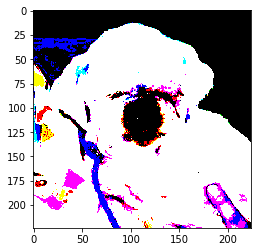

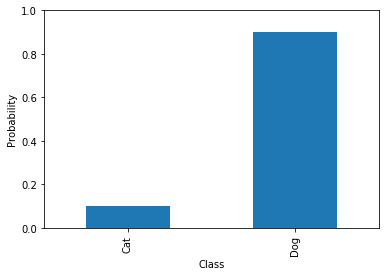

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


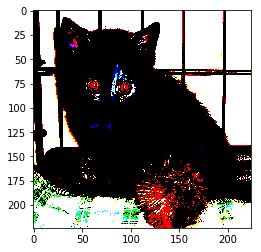

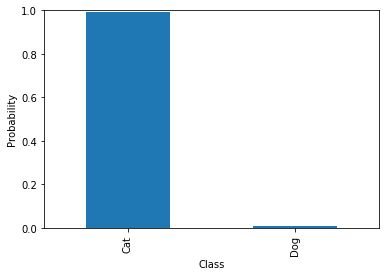

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


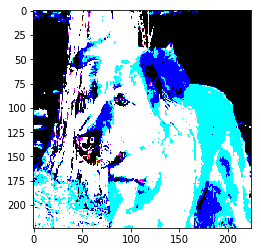

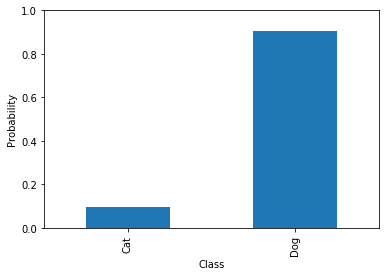

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


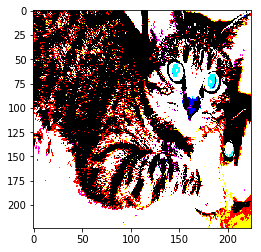

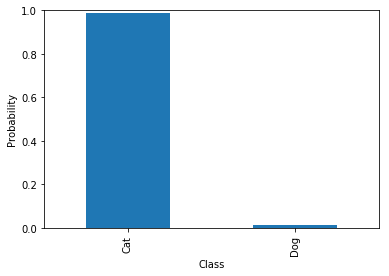

In [0]:
show_prediction_examples(num_examples=4, validation_image_generator=validation_generator, model=vgg16_model, folder_path=timestamp, model_name='vgg16')

Show 4 images and the classification prediction from ResNet-50 for those images (see helper method at top of file for more details on how this is done)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


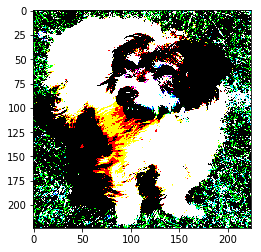

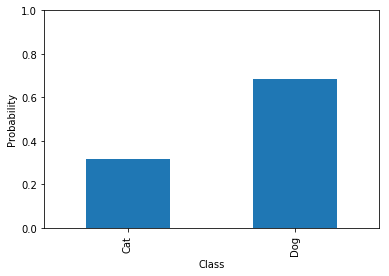

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


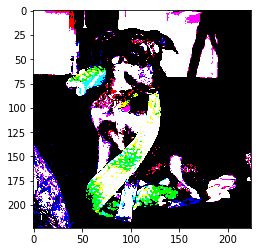

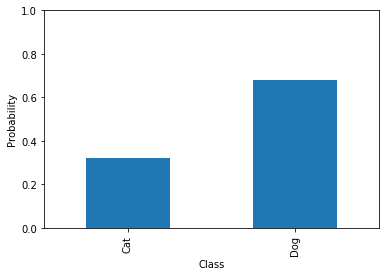

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


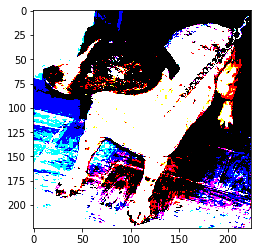

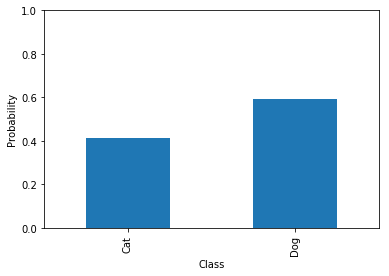

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


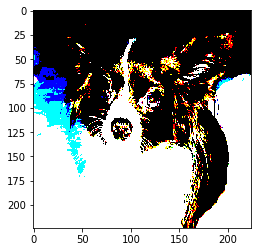

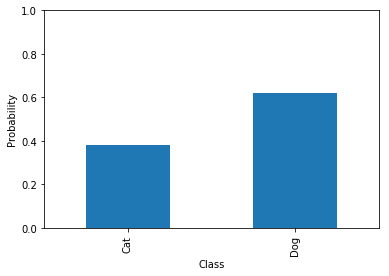

In [0]:
show_prediction_examples(num_examples=4, validation_image_generator=validation_generator, model=resnet50_model, folder_path=timestamp, model_name='resnet50')

Loop through every validation image and calculate target (actual) class and class predicted by vgg16 and resnet50
```
                      predicted
                 0 (cat)    1 (dog)
actual 0 (cat)
       1 (dog)
```

In [11]:
PREDICTION_CUTOFF = 0.5
vgg16_predcls = []
resnet50_predcls = []
targetcls = []
CAT_VAL = 0
DOG_VAL = 1
for (dirpath, dirs, files) in os.walk('data/validation'):
    for file in files:
        img_val = CAT_VAL
        if 'dog' in dirpath:
            img_val = DOG_VAL
        filepath = os.path.join(dirpath, file)
        img = plt.imread(filepath)
        vgg16_prediction = vgg16_model.predict(img)
        vgg16_predcls.append( vgg16_prediction >= PREDICTION_CUTOFF ? DOG_VAL : CAT_VAL)
        resnet50_prediction = resnet50_model.predict(img)
        resnet50_predcls.append(resnet50_prediction >= PREDICTION_CUTOFF ? DOG_VAL : CAT_VAL)
        print(filepath + ' img_val: ' + str(img_val) + ' vgg16_predict: ' + vgg16_prediction + ' resnet50_prediction: ' + resnet50_prediction)

data/validation/dogs/dog.1132.jpg is dog: 1
data/validation/dogs/dog.1349.jpg is dog: 1
data/validation/dogs/dog.1087.jpg is dog: 1
data/validation/dogs/dog.1064.jpg is dog: 1
data/validation/dogs/dog.1323.jpg is dog: 1
data/validation/dogs/dog.1287.jpg is dog: 1
data/validation/dogs/dog.1075.jpg is dog: 1
data/validation/dogs/dog.1269.jpg is dog: 1
data/validation/dogs/dog.1062.jpg is dog: 1
data/validation/dogs/dog.1277.jpg is dog: 1
data/validation/dogs/dog.1303.jpg is dog: 1
data/validation/dogs/dog.1275.jpg is dog: 1
data/validation/dogs/dog.1327.jpg is dog: 1
data/validation/dogs/dog.1067.jpg is dog: 1
data/validation/dogs/dog.1385.jpg is dog: 1
data/validation/dogs/dog.1308.jpg is dog: 1
data/validation/dogs/dog.1389.jpg is dog: 1
data/validation/dogs/dog.1270.jpg is dog: 1
data/validation/dogs/dog.1247.jpg is dog: 1
data/validation/dogs/dog.1034.jpg is dog: 1
data/validation/dogs/dog.1039.jpg is dog: 1
data/validation/dogs/dog.1030.jpg is dog: 1
data/validation/dogs/dog.1095.jp

In [0]:
vgg16_cm = skmetrics.confusion_matrix(targetcls, vgg16_predcls)
vgg16_cm
resnet50_cm = skmetrics.confusion_matrix(targetcls, resnet50_predcls)
resnet50_cm

In [0]:
predcls = []
PREDICTION_CUTOFF = 0.5
#WARNING: we are abusing the validation generator here
#It would be more correct to simply read all the images from the appropriate folders
#Remember: Dog is 1, cat is 0
for i in range(0, EPOCHS):
    X_image_batch, y_actual_values = next(validation_generator)
    for y in y_actual_values:
        targetcls.append(y)
    for x in vgg16_model.predict(X_image_batch):
        if (x >= PREDICTION_CUTOFF):
            predcls.append(1)
        else:
            predcls.append(0)
    
print(targetcls)
print(predcls)
cm = skmetrics.confusion_matrix(targetcls, predcls)
cm

[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
[1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 

array([[74,  1],
       [14, 71]])

Show the confusion matrix for ResNet-50
```
                      predicted
                 0 (cat)    1 (dog)
actual 0 (cat)
       1 (dog)
```

In [0]:
predcls = []
targetcls = []
PREDICTION_CUTOFF = 0.5
#WARNING: we are abusing the validation generator here
#It would be more correct to simply read all the images from the appropriate folders
#Remember: Dog is 1, cat is 0
for i in range(0, EPOCHS):
    X_image_batch, y_actual_values = next(validation_generator)
    for y in y_actual_values:
        targetcls.append(y)
    for x in resnet50_model.predict(X_image_batch):
        if (x >= PREDICTION_CUTOFF):
            predcls.append(1)
        else:
            predcls.append(0)
    
print(targetcls)
print(predcls)
cm = skmetrics.confusion_matrix(targetcls, predcls)
cm

[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 

array([[40, 45],
       [18, 57]])